This notebook will try and predict one NM from another one using the low dimensional embeddings from CEBRA.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.utils as cp
import sklearn.linear_model


from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/anaconda3/envs/cebra_packenv/lib/python3.10/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
pd.__version__

'2.2.2'

In [3]:
#pip install pandas==2.0.0

In [3]:
# load the dataframe that contains data from 1 session
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [4]:
n_trials = 1765

In [5]:
# download the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [6]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [7]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [11]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)
all_nms.shape

(218572, 4)

## B. Format the Data

In [12]:
# get all NMs
formatted_nms, reward_labels, choice_labels, rpe_labels_ = cp.format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [15]:
# get individual NMs
ind_nms = cp.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [18]:
formatted_ind_nms = [cp.format_data(ind_nm, df_trials_ses, trace_times, choice_times)[0] for ind_nm in ind_nms]

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [14]:
rewarded, unrewarded = cp.define_label_classes(reward_labels)

In [23]:
torch. cuda. is_available()

False

In [28]:
formatted_ind_nms[0].shape

torch.Size([1717, 20])

## C. Build and train the CEBRA model then compute embeddings

In [25]:
# train CEBRA on all nms then produce embeddings for individual nms
def multi_embed_NMs(all_nms, ind_nms, b_label, max_iterations=2000, d=3, metric='euclidean', arch = 'offset10-model-mse'):


    # build time and behaviour models
    cebra_time_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10) 

    cebra_behaviour_model = CEBRA(model_architecture=arch,
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=d,
                        max_iterations=max_iterations,
                        distance=metric,
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

    # train them both
    cebra_time_model.fit(all_nms)
    cebra_behaviour_model.fit(all_nms, b_label)

    # compute the embeddings
    time_embeddings = [cebra_time_model.transform(ind_nm) for ind_nm in ind_nms]
    behaviour_embeddings = [cebra_behaviour_model.transform(ind_nm) for ind_nm in ind_nms]

    return time_embeddings, behaviour_embeddings

In [29]:
formatted_nms.shape

torch.Size([1717, 80])

In [31]:
formatted_ind_nms[0].shape

torch.Size([1717, 20])

In [26]:
time_embeddings, behaviour_embeddings = multi_embed_NMs(all_nms=formatted_nms, ind_nms=formatted_ind_nms,b_label=reward_labels)

pos:  0.9336 neg:  2.8488 total:  3.7824 temperature:  1.0000: 100%|██████████| 2000/2000 [00:30<00:00, 65.30it/s]
pos:  0.2886 neg:  5.4575 total:  5.7461 temperature:  1.0000: 100%|██████████| 2000/2000 [00:31<00:00, 63.96it/s]


RuntimeError: Given groups=1, weight of size [32, 80, 2], expected input[1, 20, 1726] to have 80 channels, but got 20 channels instead

# D. Analysis

Steps:
- Train one model on all NMs
- Compute embedding for the individual NMs
- Make regression model and predict one NM from another

In [18]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(17,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
    
    for ax in [ax81,ax82]:
        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=size, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=size, title='Time embedding, AUC: {}'.format(np.round(mean_scores[0],2)), cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82, markersize=size, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82,markersize=size, title='Behaviour embedding, AUC: {}'.format(np.round(mean_scores[1],2)),  cmap=colours[1])

    gs.tight_layout(figure=fig)

NameError: name 'mean_scores' is not defined

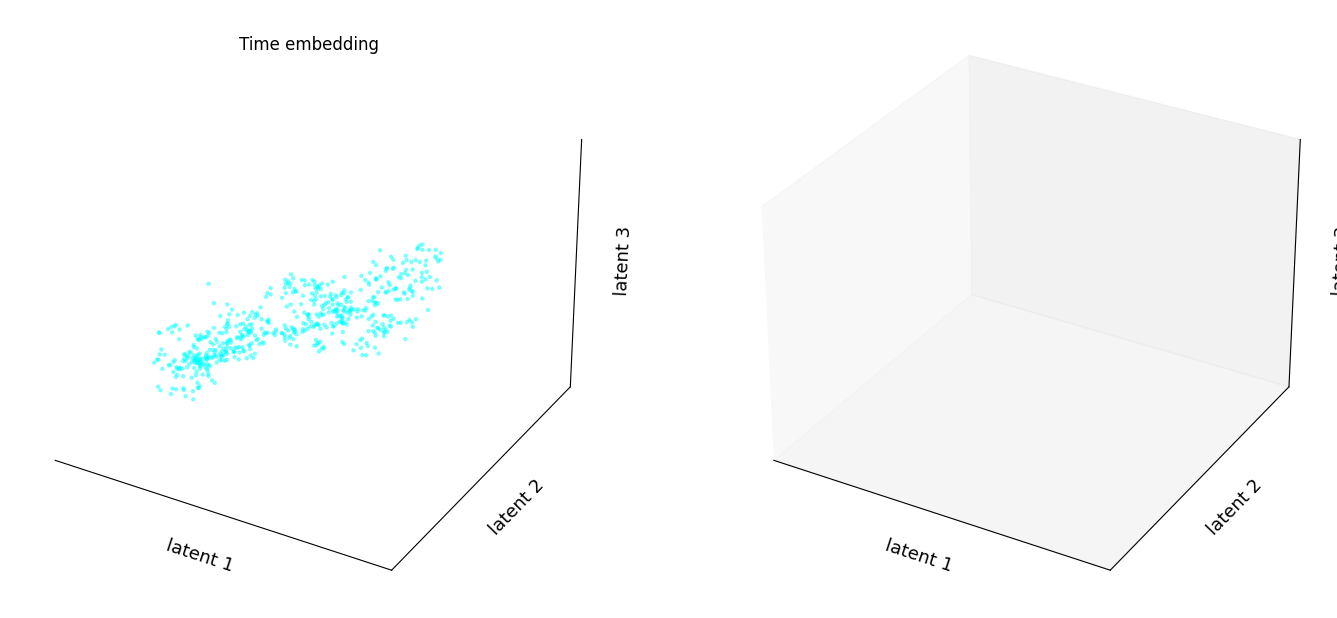

In [19]:
view(t_embed, b_embed, reward_labels, [rewarded,unrewarded])

In [37]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels , l_class, means=None, titles=['DA only', 'NE only', '5HT only', 'ACh only'], t=""):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = n_plots//n_columns

    # create axis
    fig = plt.figure(figsize=(8,4*2))
    gs = gridspec.GridSpec(2, 2, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


        if means.any():
            titles=['DA only, AUC:{}'.format(means[0]),'NE only, AUC:{}'.format(means[1]), '5HT only, AUC:{}'.format(means[2]), 'ACh only, AUC:{}'.format(means[3])]


        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    plt.suptitle(t, fontsize=15)
    plt.tight_layout()